### Exploring the annotated data.

In [1]:
from datasets import load_dataset, disable_caching
import pandas as pd

# can infer the generic loader script this easily
disable_caching()
# cache location [click](%userprofile%/.cache/huggingface/datasets)
# needs force_redownload to avoid loading incorrect cached stuff
ds = load_dataset("json", data_dir="./data/annotated/", download_mode="force_redownload", cache_dir=None)
df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
ds

Resolving data files:   0%|          | 0/95 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/19622 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions', 'test'],
        num_rows: 19622
    })
})

In [2]:
# #344 seems to crash/hang up and ruin the kernel. (works isolated?)
# run_shader(ds["train"][344])

In [72]:
# this spawns a subprocess that calls naga to validate/translate a fragment shader to check for rust panics
from wgpu_shadertoy.passes import builtin_variables_glsl, fragment_code_glsl
import tempfile
import subprocess

def validate_shader(row):
    image_code = row["image_code"]
    fragment_code = builtin_variables_glsl + image_code + fragment_code_glsl
    with tempfile.NamedTemporaryFile(mode="w", suffix=".frag", encoding="utf-8") as f:
        f.write(fragment_code)
        f.flush()
        try:
            subprocess.run(["naga", f.name], check=True, capture_output=True, timeout=5)
            return "valid"
        except subprocess.SubprocessError as e:
            if isinstance(e, subprocess.TimeoutExpired):
                return "timedout"
            # return e.stderr.decode("utf-8")
            return "error"
        return "valid"


In [73]:
# took like 17 minutes on my PC and looks like some timeouts do happen... no hangups just yet.
# we had some cases where translation is needed instead of just validation to spot panics...

# we do sometimes have image_inputs but do not have the input headers... meaning shaders with inputs will return an error...

def run_validation(row):
    valid = validate_shader(row)
    return {"validation" : valid}
ds = ds.map(run_validation)

Map:   0%|          | 0/19622 [00:00<?, ? examples/s]

c:\Users\Jan\AppData\Local\Programs\Python\Python39\lib\subprocess.py:1231: RuntimeWarning: coroutine 'run_validation' was never awaited
  stack.callback(os.close, devnull_fd)


In [76]:
#redo the df

df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
#

In [77]:
df["validation"].value_counts().head(10)

validation
valid       14870
error        4728
timedout       24
Name: count, dtype: int64

In [78]:
# list of permissive licenses like: https://huggingface.co/datasets/bigcode/the-stack-v2/blob/main/license_stats.csv (gated?)
# maybe this instead: https://huggingface.co/datasets/bigcode/the-stack/blob/main/licenses.json
# seems to be the one they actually use: https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt 

import requests
permissive_list = requests.get("https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt").content.decode("utf-8").split()
permissive_list = [l.lower() for l in permissive_list]

print(len(permissive_list))


824


In [96]:

print(ds["train"].unique("license"))
# filter permissive licenses
permissive_ds = ds["train"].filter(lambda x: x["license"].lower() in permissive_list) #what about those AND and OR classifications?
permissive_ds = permissive_ds.filter(lambda x: x["validation"] == "valid")
permissive_ds

['CC-BY-NC-SA-3.0', 'cc-by-nc-sa-3.0', 'bsd-new', 'mit', 'cc-by-4.0', 'proprietary-license', 'cc-by-nc-nd-3.0', 'bsd-simplified', 'cc0-1.0', 'unknown-license-reference', 'public-domain', 'apache-2.0', 'cc-by-nc-sa-4.0', 'agpl-3.0', 'cc-by-sa-3.0', 'cc-by-3.0', 'cc-by-sa-2.5', 'cc-by-sa-4.0', 'cc-by-sa-4.0 WITH generic-exception', 'cc-by-3.0 AND mit', 'cc-by-nc-sa-2.0', 'cc-by-nc-sa-3.0 AND proprietary-license', 'wtfpl-2.0', 'gpl-3.0', 'cc-by-4.0 OR cc-by-3.0', 'beerware', 'gpl-3.0-plus OR cc-by-sa-3.0', 'unlicense', 'cc-by-nc-nd-4.0', 'warranty-disclaimer', 'x11', 'gpl-3.0-plus', 'cc-by-nc-4.0', 'cc-by-2.5', 'cc0-1.0 OR openssl-ssleay OR apache-2.0', 'gpl-2.0', 'gpl-2.0-plus', 'cc-by-nc-3.0', 'gpl-1.0-plus', 'artistic-2.0', 'cc-sampling-plus-1.0']


Filter:   0%|          | 0/19622 [00:00<?, ? examples/s]

Filter:   0%|          | 0/660 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions', 'test', 'validation'],
    num_rows: 509
})

In [97]:
# seems to never contain any common pass? or my preprocessing is wrong.
print(df["common_code"].unique()) 

# see how many shaders contain buffer passes (seemingly none?)
ds["train"].filter(lambda x: x["buffer_a_code"] + x["buffer_b_code"] + x["buffer_c_code"] + x["buffer_d_code"] != "")

['']


Filter:   0%|          | 0/19622 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions', 'test', 'validation'],
    num_rows: 0
})

<Axes: title={'center': 'license'}, xlabel='date'>

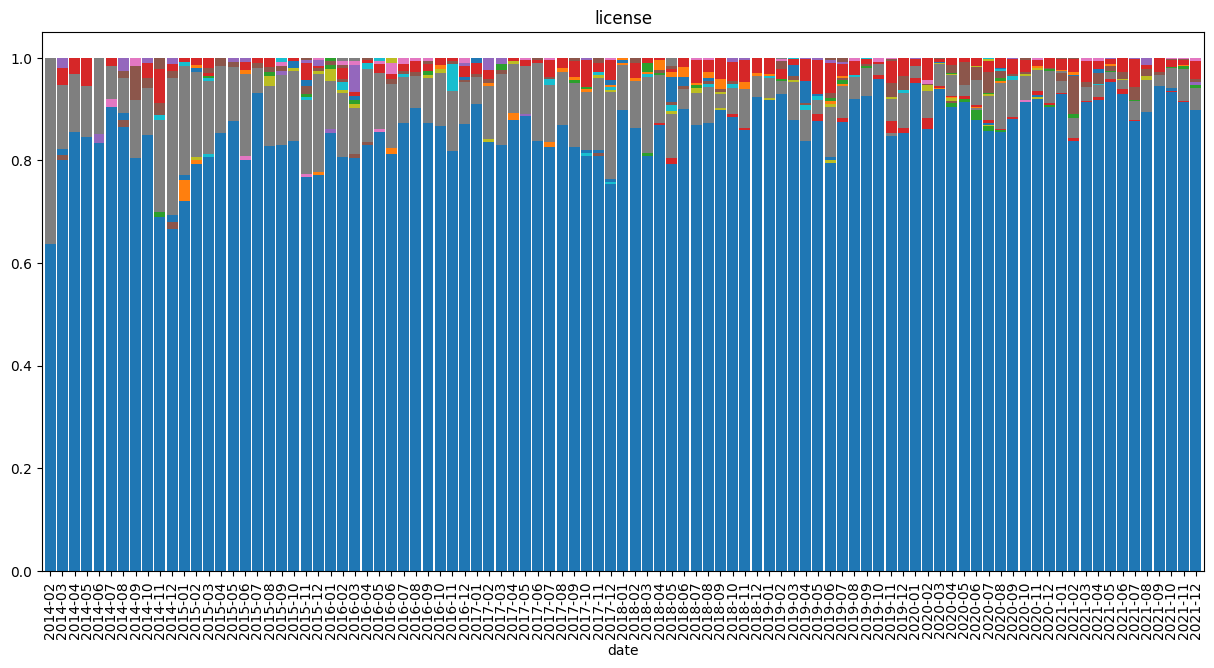

In [98]:
def plot_per_month(column, stretched=False, **kwargs):
    feature_df = df["date"].groupby([df["date"].dt.to_period("M"), df[column]]).count().unstack()
    if stretched:
        feature_df = feature_df.div(feature_df.sum(axis=1), axis=0)
    return feature_df.plot(kind="bar", stacked=True, figsize=(15,7), title=column, width=.9, **kwargs)
    
plot_per_month("license", True, legend=False)

<Axes: title={'center': 'published'}, xlabel='date'>

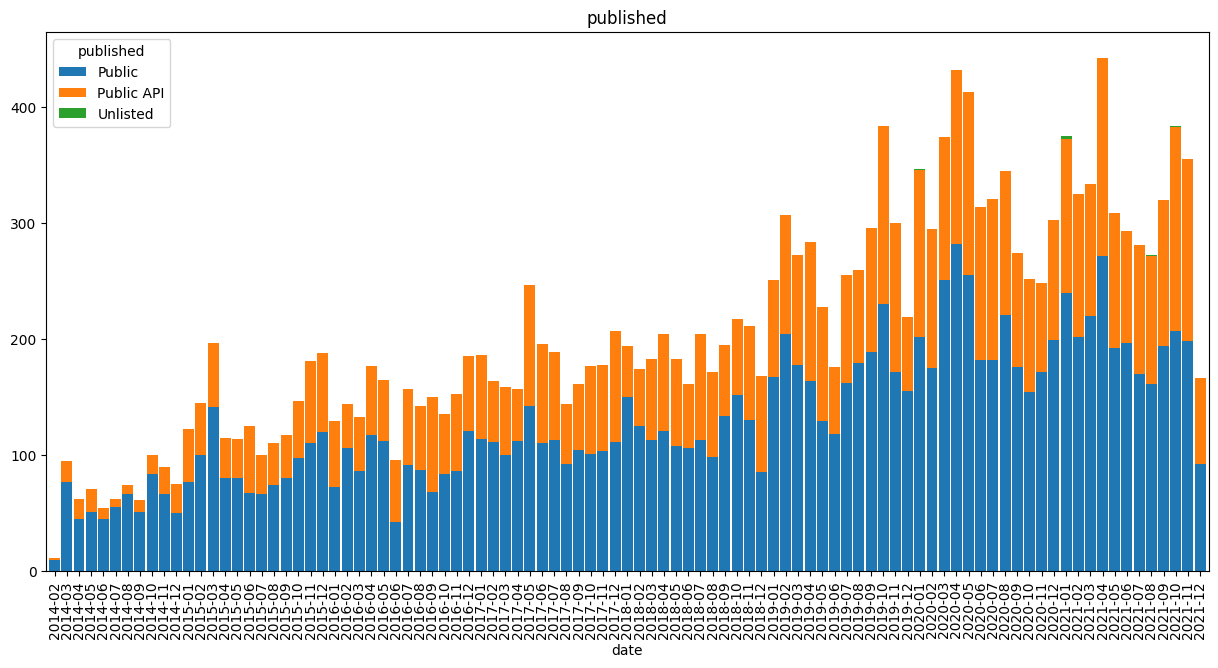

In [99]:
plot_per_month("published", False)

<Axes: title={'center': 'test'}, xlabel='date'>

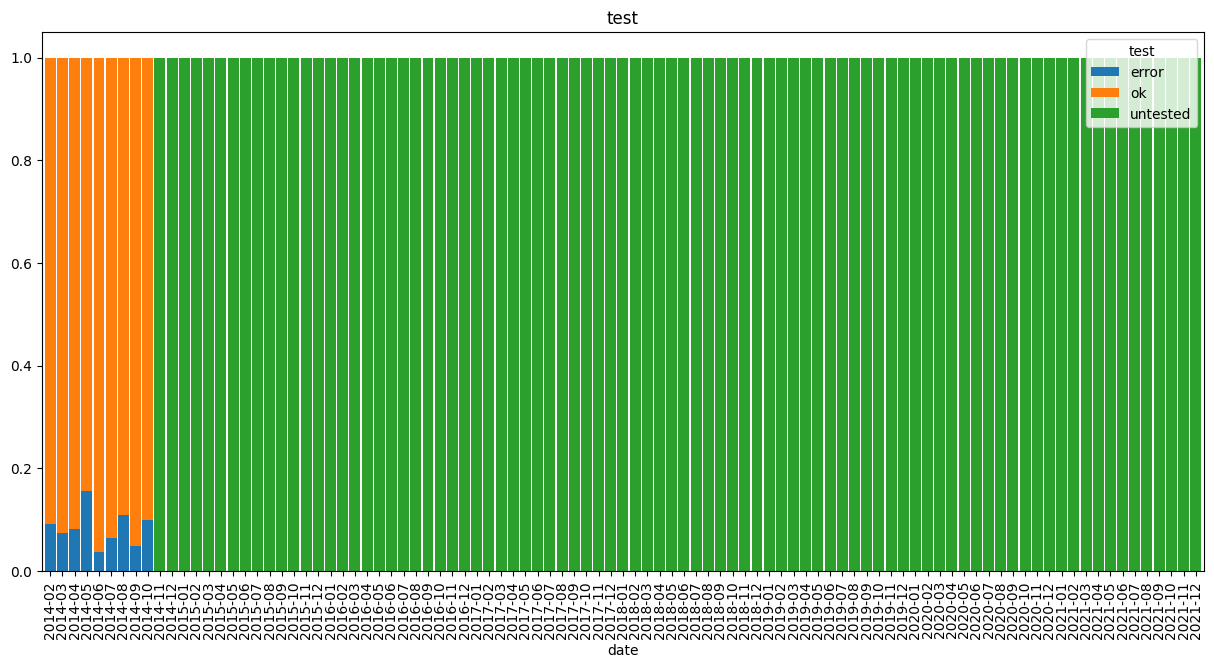

In [100]:
# currently in development, another filtering step.
plot_per_month("test", stretched=True, legend=True)

<Axes: title={'center': 'validation'}, xlabel='date'>

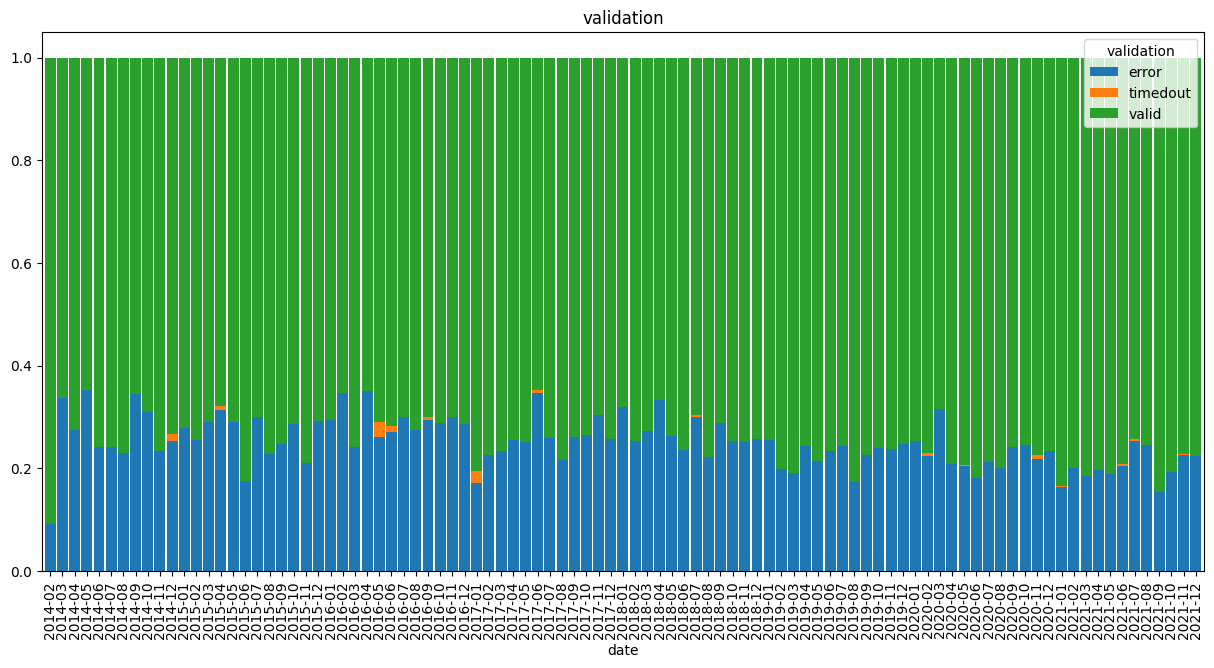

In [101]:
plot_per_month("validation", stretched=True, legend=True)

In [103]:
df["num_functions"] = df["functions"].apply(len)
df["num_functions"].describe()

count    19622.000000
mean         8.108450
std         10.439794
min          0.000000
25%          2.000000
50%          5.000000
75%         10.000000
max        358.000000
Name: num_functions, dtype: float64

<Axes: title={'center': 'num_inputs'}, xlabel='date'>

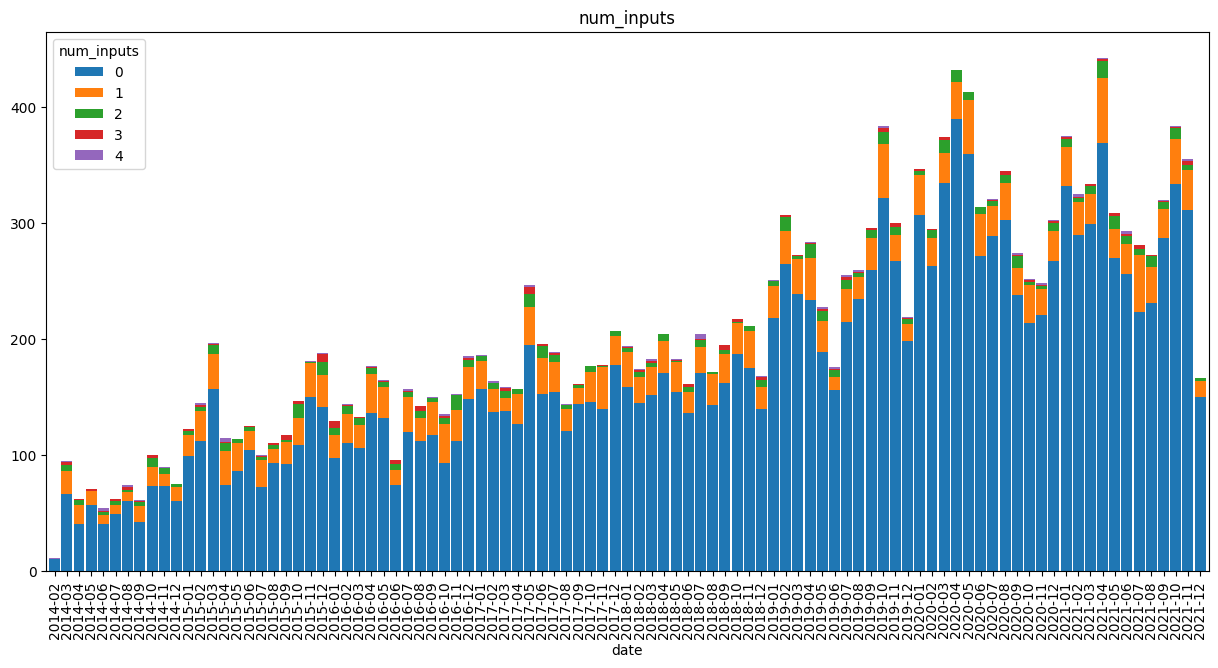

In [104]:
df["num_inputs"] = df["image_inputs"].apply(len)
plot_per_month("num_inputs", stretched=False, legend=True)

In [105]:
# these cases might be parsing failures? seem to always use macros inside functions or something.
# some use no functions but Main(){...} which seems to work in glsl but not viable for our dataset
from annotate import PARSER
print(PARSER.parse(bytes(df["image_code"][5090],encoding="utf-8")).root_node.has_error)
df.loc[df["num_functions"] == 0]

False


,id,name,author,description,tags,likes,viewed,published,date,time_retrieved,...,cube_a_code,cube_a_inputs,thumbnail,access,license,functions,test,validation,num_functions,num_inputs
62,Md23DV,GLSL 2D Tutorials,vug,28 tutorials on writing pixel shaders at Shade...,[tutorial],581,48910,Public,2014-03-08 20:58:49,2021-10-01,...,,[],https://www.shadertoy.com/media/shaders/Md23DV...,shaders20k,CC-BY-NC-SA-3.0,[],ok,error,0,3
4809,MsSyzW,2D Worley and Cell Noise,TinyTexel,left: 1 - worley\nmiddle: f2^2 - f1^2\nright: ...,"[voronoi, noise, worley]",12,348,Public,2017-04-01 18:38:57,2021-10-01,...,,[],https://www.shadertoy.com/media/shaders/MsSyzW...,shaders20k,CC-BY-NC-SA-3.0,[],untested,valid,0,0
5090,XtySDz,Shadertoy 튜토리얼 한글번역,ho4040,Korean version of https://www.shadertoy.com/vi...,"[tutorial, korean]",7,1040,Public API,2017-05-26 03:06:13,2021-10-01,...,,[],https://www.shadertoy.com/media/shaders/XtySDz...,shaders20k,CC-BY-NC-SA-3.0,[],untested,error,0,0
5626,4lfczB,Sphere over lake,Nowado,Any description,[sphere],6,444,Public API,2017-09-14 10:06:26,2021-10-01,...,,[],https://www.shadertoy.com/media/shaders/4lfczB...,shaders20k,CC-BY-NC-SA-3.0,[],untested,valid,0,0
5743,XlfcD4,dizzy,sgoal,dizzy,[dizzy],0,66,Public,2017-09-07 04:35:57,2021-10-01,...,,[],https://www.shadertoy.com/media/shaders/XlfcD4...,shaders20k,CC-BY-NC-SA-3.0,[],untested,valid,0,0
5746,XlfyRj,Dancing Star,SunLuke,dance,[huehe],2,116,Public,2017-09-14 12:56:59,2021-10-01,...,,[],https://www.shadertoy.com/media/shaders/XlfyRj...,shaders20k,CC-BY-NC-SA-3.0,[],untested,valid,0,0
8489,llGfW3,rolling triangle tiling (310 ch),FabriceNeyret2,"Funnily, drawing all triangles makes [url]http...","[2d, geometry, gif, short, reproductions]",9,493,Public API,2018-12-07 21:29:36,2021-10-01,...,,[],https://www.shadertoy.com/media/shaders/llGfW3...,shaders20k,CC-BY-NC-SA-3.0,[],untested,valid,0,0
9948,wtX3zB,Almost My First Shader,dr2,See the source...,"[raymarch, landscape, flight, car]",10,602,Public API,2019-05-01 09:54:07,2021-10-01,...,,[],https://www.shadertoy.com/media/shaders/wtX3zB...,shaders20k,cc-by-nc-sa-3.0,[],untested,error,0,0
11273,WsGGWy,Move in circle ( tutorial ),Kiltun,A simple shader of a circle moving on a ring.\...,"[tutorial, circle, ring, move, moveincircle]",1,172,Public,2019-10-11 16:30:36,2021-10-01,...,,[],https://www.shadertoy.com/media/shaders/WsGGWy...,shaders20k,CC-BY-NC-SA-3.0,[],untested,valid,0,0
15144,WdyyDR,Great Ideas in Graphics Demo,sjobalia,Demo for Great Ideas in Graphics,[demo],1,98,Public,2020-10-12 22:55:41,2021-10-01,...,,[],https://www.shadertoy.com/media/shaders/WdyyDR...,shaders20k,CC-BY-NC-SA-3.0,[],untested,error,0,0


In [106]:
# TODO: refactor into a generator because I dislike the current shape. but figure out how batching and threadding works then?
# part of the filter.py or prepare.py script that will be done soon.
def split_functions(batch):
    # per function fields
    comments, headers, docstrings, bodies = [],[],[],[]
    # per document fields
    full_code, funcs, ids = [],[],[]
    for code, func_bytes, shader_id in zip(batch["image_code"], batch["functions"], batch["id"]):
        row_code = bytes(code,encoding="utf-8")
        for start_comment, start_header, end_header, end_docstring, end_function in func_bytes:
            comments.append(row_code[start_comment:start_header].decode(encoding="utf-8")),
            headers.append(row_code[start_header:end_header].decode(encoding="utf-8")),
            docstrings.append(row_code[end_header:end_docstring].decode(encoding="utf-8")),
            bodies.append(row_code[end_docstring:end_function].decode(encoding="utf-8")),
            full_code.append(row_code.decode(encoding="utf-8")),
            funcs.append((start_comment, start_header, end_header, end_docstring, end_function))
            ids.append(shader_id)
    return {
            "comment": comments,
            "header": headers,
            "docstring": docstrings,
            "body": bodies,
            "full_code": full_code,
            "func_bytes": funcs,
            "id": ids,
            }


# func_ds = ds.map(split_functions, batched=True, remove_columns=ds["train"].column_names) # full dataset to functions
func_ds = permissive_ds.map(split_functions, batched=True, remove_columns=permissive_ds.column_names) # only permissive shaders (the whole 20k set is single pass without common...)
if "train" in func_ds:
    func_ds = func_ds["train"]
func_ds

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'comment', 'header', 'docstring', 'body', 'full_code', 'func_bytes'],
    num_rows: 4162
})

In [107]:
func_df = func_ds.to_pandas()
func_df.head() 

,id,comment,header,docstring,body,full_code,func_bytes
0,lsS3Wc,//============================================...,vec3 hsv2rgb( in vec3 c )\n{,,\n vec3 rgb = clamp( abs(mod(c.x*6.0+vec3(0...,// The MIT License\n// Copyright © 2014 Inigo ...,"[1143, 1250, 1277, 1277, 1406]"
1,lsS3Wc,,vec3 hsl2rgb( in vec3 c )\n{,,\n vec3 rgb = clamp( abs(mod(c.x*6.0+vec3(0...,// The MIT License\n// Copyright © 2014 Inigo ...,"[1408, 1408, 1435, 1435, 1577]"
2,lsS3Wc,,vec3 rgb2hsv( in vec3 c)\n{,,"\n vec4 k = vec4(0.0, -1.0/3.0, 2.0/3.0, -1...",// The MIT License\n// Copyright © 2014 Inigo ...,"[1579, 1579, 1605, 1605, 1920]"
3,lsS3Wc,,vec3 rgb2hsl( vec3 col )\n{,,"\n float minc = min( col.r, min(col.g, col....",// The MIT License\n// Copyright © 2014 Inigo ...,"[1922, 1922, 1948, 1948, 2400]"
4,lsS3Wc,//============================================...,"void mainImage( out vec4 fragColor, in vec2 fr...",,\n\tvec2 uv = fragCoord.xy / iResolution.xy;\n...,// The MIT License\n// Copyright © 2014 Inigo ...,"[2402, 2478, 2535, 2535, 2722]"


In [114]:
func_df["has_comment"] = func_df["comment"] != ""
func_df["has_docstring"] = func_df["docstring"] != ""
func_df["model_ctx"] = func_df["comment"] + func_df["header"] + func_df["comment"]
# how many functions are there, and what is the share of comments, 

xtab = pd.crosstab(func_df["has_comment"], func_df["has_docstring"], margins=True)
print(f"functions with context = {xtab.iloc[-1,-1] - xtab.iloc[0,0]}")
xtab

# for the permissive subset of shaders 21k the number goes down to like 253 for both... and 174 for valid shaders only.

functions with context = 1640


has_docstring,False,True,All
has_comment,,,
False,2522,204,2726
True,1262,174,1436
All,3784,378,4162


In [115]:
# FINDING: only about half the comments are unique.
# some frequent comment looks like a template maybe? should investigate
print(func_df["comment"].nunique())
func_df["comment"].value_counts(sort=True, ascending=False).head(10)

934


comment
                                                                                                                                                                                                                                                         2726
//------------------------------------------------------------------\n\n                                                                                                                                                                                   44
// http://iquilezles.org/www/articles/normalsSDF/normalsSDF.htm\n                                                                                                                                                                                          29
// http://iquilezles.org/www/articles/rmshadows/rmshadows.htm\n                                                                                                                                                                       

In [116]:
# FINDING = only about a third of function-headers are unique?
# it's expect to have one mainImage function per renderpass... but they are just whitesapce variable here - maybe we skip them in general
print(func_df["header"].nunique())
func_df["header"].value_counts(sort=True, ascending=False).head(10)

2086


header
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{    396
float scene(vec3 p) {                                          49
vec3 erot(vec3 p, vec3 ax, float ro) {                         45
vec3 norm(vec3 p) {                                            44
void mainImage(out vec4 fragColor, in vec2 fragCoord) {        44
vec3 calcNormal( in vec3 pos )\n{                              37
float dot2( in vec2 v ) {                                      20
vec3 mod289(vec3 x) {                                          20
float calcAO( in vec3 pos, in vec3 nor )\n{                    20
void mainImage( out vec4 fragColor, in vec2 fragCoord ) {      19
Name: count, dtype: int64

In [117]:
# looks like some are not exact or might even use the common pass to bypass this
func_df["header"].str.startswith("void mainImage").sum()

509

In [118]:
# half the docstrings aren't unique?
# most common one is the shadertoy.com/new default for the main function
print(func_df["docstring"].nunique())
func_df["docstring"].value_counts(sort=True, ascending=False).head(10)

195


docstring
                                                                                           3784
\n    // Normalized pixel coordinates (from 0 to 1)                                          23
\n    // filter kernel                                                                       18
\n     // camera movement\t                                                                  18
\n//  return tanh(x);                                                                        14
\n    //sdf is undefined outside the unit sphere, uncomment to witness the abominations      12
\n    // normalized pixel coordinates                                                        10
\n    // bounding volume                                                                      9
\n\t//get coords and direction                                                                8
 \n    // background                                                                          6
Name: count, dtype: int64

In [119]:
# proposed model_ctx takes all of them in normal order (doens't filter out the naked functions)
print(func_df["model_ctx"].nunique())
func_df["model_ctx"].value_counts(sort=True, ascending=False).head(10)

2378


model_ctx
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{                                                                                                             354
float scene(vec3 p) {                                                                                                                                                   48
vec3 norm(vec3 p) {                                                                                                                                                     44
void mainImage(out vec4 fragColor, in vec2 fragCoord) {                                                                                                                 42
// http://iquilezles.org/www/articles/normalsSDF/normalsSDF.htm\nvec3 calcNormal( in vec3 pos )\n{// http://iquilezles.org/www/articles/normalsSDF/normalsSDF.htm\n     25
float calcAO( in vec3 pos, in vec3 nor )\n{                                                                                            

In [121]:
# figure out if a function is needed, by removing if from body and check if the code still runs (you should have filtered for only working shaders before)

# step 1. subset the dataframe to only those rows that have comment and docstring
both_df = func_df[func_df["has_comment"] & func_df["has_docstring"]]
# 253 functions form 168 shaders, only 179 of which are unique combinations...
both_df["header"].value_counts(sort=True, ascending=False).head(10)

header
float tanh_approx(float x) {                                                       12
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{                         10
float calcSoftshadow( in vec3 ro, in vec3 rd, in float mint, in float tmax )\n{     9
float checkersGradBox( in vec2 p )\n{                                               9
float checkersGradBox( in vec2 p, in vec2 dpdx, in vec2 dpdy )\n{                   7
vec2 map( in vec3 p, int id )\n{                                                    4
float map( in vec3 p )\n{                                                           3
mat3 rproject(vec3 p0, vec3 p1, vec3 p2, vec3 p3) {                                 3
vec2 iBox( in vec3 ro, in vec3 rd, in vec3 cen, in vec3 rad ) \n{                   3
vec3 render( in vec3 ro, in vec3 rd )\n{                                            2
Name: count, dtype: int64

In [122]:
# step 2. if code runs without the function.
from annotate import run_shader

def check_function_needed(row):
    code = row["full_code"]
    start_comment, start_header, end_header, end_docstring, end_function = row["func_bytes"]
    test_code = code[:start_comment] + code[end_function:]
    status = run_shader(test_code)
    return status == "error"


both_df["needed"] = both_df.apply(check_function_needed, axis=1)
both_df["needed"].value_counts()

C:\Users\Jan\AppData\Local\Temp\ipykernel_13780\3626809373.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_df["needed"] = both_df.apply(check_function_needed, axis=1)


needed
True     173
False      1
Name: count, dtype: int64

In [123]:
# step 3. check if the whole code works originally

def check_code(row):
    code = row["full_code"]
    status = run_shader(code)
    return status

both_df["status"] = both_df.apply(check_code, axis=1)

: 

In [ ]:
both_df["status"].value_counts()